# W266 Final Project

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

*TODO*

- Introduction
- Literature review

## Downloading and loading the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [1]:
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn.metrics import classification_report

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [4]:
con = sqlite3.connect('data/yelpResData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

con = sqlite3.connect('data/yelpHotelData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('review',), ('restaurant',), ('reviewer',)]
[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]


In [5]:
# Reading from the hotels database
hotels_db = sqlite3.connect("data/yelpHotelData.db")
hotels = pd.read_sql_query("SELECT * FROM hotel", hotels_db)
hotel_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", hotels_db)
hotel_reviewers = pd.read_sql_query("SELECT * FROM reviewer", hotels_db)


print(f'The data set contains {len(hotels)} hotels, {len(hotel_reviews)} reviews, and {len(hotel_reviewers)} reviewers')

The data set contains 283086 hotels, 5858 reviews, and 5123 reviewers


In [6]:
# Reading from the restaurant database
restaurant_db = sqlite3.connect("data/yelpResData.db")
restaurant_db.text_factory = lambda x: x.decode("utf-8", errors='ignore')
restaurants = pd.read_sql_query("SELECT * FROM restaurant", restaurant_db)
restaurant_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", restaurant_db)
restaurant_reviewers = pd.read_sql_query("SELECT * FROM reviewer", restaurant_db)


print(f'The data set contains {len(restaurants)} restaurants, {len(restaurant_reviews)} reviews, and {len(restaurant_reviewers)} reviewers')

The data set contains 242652 restaurants, 67019 reviews, and 16941 reviewers


In [7]:
# Data Cleaning
hotel_reviews['reviewContent'] = hotel_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
hotel_reviews['date'] = hotel_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))

restaurant_reviews['reviewContent'] = restaurant_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
restaurant_reviews['date'] = restaurant_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))


In [8]:
# Split data according to the research paper
hotel_X_test = hotel_reviews[hotel_reviews['date'] >= datetime.datetime(2012, 1, 1)]
hotel_y_test = hotel_X_test['flagged'] == 'Y'
hotel_X_tran_and_dev = hotel_reviews[hotel_reviews['date'] < datetime.datetime(2012, 1, 1)]
hotel_X_train, hotel_X_dev, hotel_y_train, hotel_y_dev = train_test_split(hotel_X_tran_and_dev, hotel_X_tran_and_dev['flagged']=='Y')

restaurant_X_test = restaurant_reviews[restaurant_reviews['date'] >= datetime.datetime(2012, 1, 1)]
restaurant_y_test = restaurant_X_test['flagged'] == 'Y'
restaurant_X_tran_and_dev = restaurant_reviews[restaurant_reviews['date'] < datetime.datetime(2012, 1, 1)]
restaurant_X_train, restaurant_X_dev, restaurant_y_train, restaurant_y_dev = train_test_split(restaurant_X_tran_and_dev, restaurant_X_tran_and_dev['flagged']=='Y')


# Exploratory Data Analysis

## ToDo: Performan More EDA

In [9]:
hotel_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3402 entries, 3186 to 284
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3402 non-null   datetime64[ns]
 1   reviewID       3402 non-null   object        
 2   reviewerID     3402 non-null   object        
 3   reviewContent  3402 non-null   object        
 4   rating         3402 non-null   int64         
 5   usefulCount    3402 non-null   int64         
 6   coolCount      3402 non-null   int64         
 7   funnyCount     3402 non-null   int64         
 8   flagged        3402 non-null   object        
 9   hotelID        3402 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 292.4+ KB


In [10]:
restaurant_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42086 entries, 32365 to 48633
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           42086 non-null  datetime64[ns]
 1   reviewID       42086 non-null  object        
 2   reviewerID     42086 non-null  object        
 3   reviewContent  42086 non-null  object        
 4   rating         42086 non-null  int64         
 5   usefulCount    42086 non-null  int64         
 6   coolCount      42086 non-null  int64         
 7   funnyCount     42086 non-null  int64         
 8   flagged        42086 non-null  object        
 9   restaurantID   42086 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 3.5+ MB


In [11]:
reviews = pd.concat([restaurant_X_train, hotel_X_train.rename(columns={'hotelID':'restaurantID'})], ignore_index=True)
reviews.groupby('reviewerID').agg({"usefulCount": np.sum, 
                                   "coolCount": np.sum, 
                                   "funnyCount": np.sum}).sort_values(by=['usefulCount'], ascending=False)
reviews[reviews['reviewerID'] == 'w-w-k-QXosIKQ8HQVwU6IQ']['reviewContent']

24492    ***Alinea is truly a one-of-a-kind experience;...
38981    ***Longman & Eagle is a true gastropub--a casu...
45209    ***While the rooms are small, Hotel Felix is a...
Name: reviewContent, dtype: object

In [12]:
reviews.groupby('flagged').agg('sum')


,rating,usefulCount,coolCount,funnyCount
flagged,,,,
N,158030,44343,29319,24954
Y,21506,0,0,0


,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,1408,1408,1408,1408,1408,1408,1408,1408,1408
2,2873,2873,2873,2873,2873,2873,2873,2873,2873
3,5924,5924,5924,5924,5924,5924,5924,5924,5924
4,15316,15316,15316,15316,15316,15316,15316,15316,15316
5,14368,14368,14368,14368,14368,14368,14368,14368,14368


(array([ 1408.,     0.,  2873.,     0.,     0.,  5924.,     0., 15316.,
            0., 14368.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

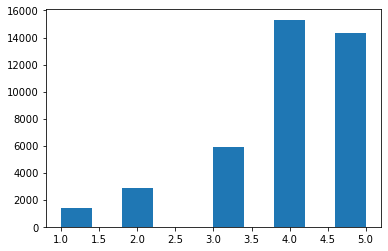

In [13]:
trueReviews = reviews[reviews['flagged'] == 'N']
fakeReviews = reviews[reviews['flagged'] == 'Y']
display(trueReviews.groupby('rating').agg('count'))
plt.hist(x=trueReviews.rating, bins=10)

,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,673,673,673,673,673,673,673,673,673
2,442,442,442,442,442,442,442,442,442
3,488,488,488,488,488,488,488,488,488
4,1495,1495,1495,1495,1495,1495,1495,1495,1495
5,2501,2501,2501,2501,2501,2501,2501,2501,2501


(array([ 673.,    0.,  442.,    0.,    0.,  488.,    0., 1495.,    0.,
        2501.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

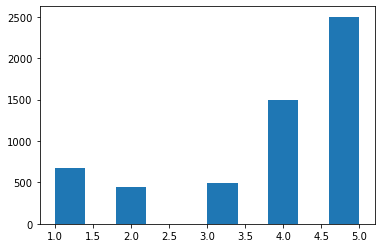

In [14]:
display(fakeReviews.groupby('rating').agg('count'))
plt.hist(x=fakeReviews.rating, bins=10)

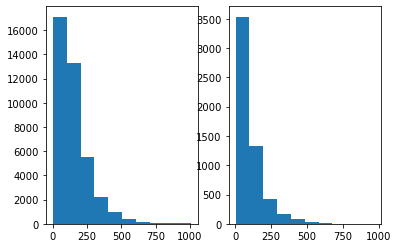

In [15]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count(' ') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count(' ') + 1)
plt.show()

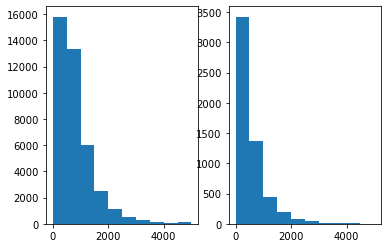

In [16]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count('.') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count('.') + 1)
plt.show()

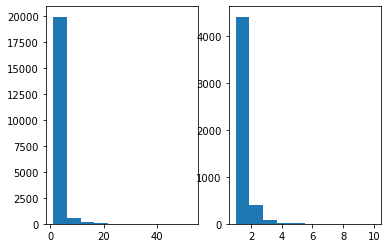

In [17]:
trueReviewerCounts = trueReviews.groupby(['reviewerID']).size().reset_index(name='counts')
fakeReviewerCounts = fakeReviews.groupby(['reviewerID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueReviewerCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviewerCounts['counts'], bins=10)
plt.show()


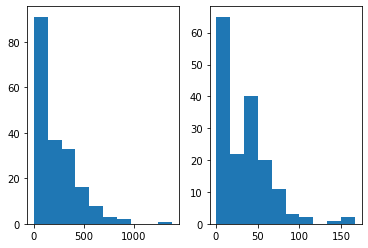

In [18]:
trueRestReviewCounts = trueReviews.groupby(['restaurantID']).size().reset_index(name='counts')
fakeRestReviewCounts = fakeReviews.groupby(['restaurantID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueRestReviewCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeRestReviewCounts['counts'], bins=10)
plt.show()


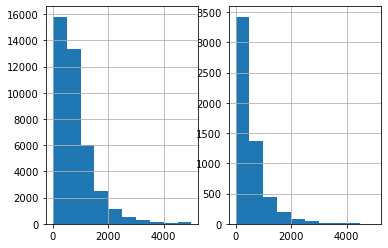

In [19]:
plt.subplot(1, 2, 1)
trueReviews['reviewContent'].str.len().hist()
plt.subplot(1, 2, 2)
fakeReviews['reviewContent'].str.len().hist()
plt.show()




[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yizhang7210/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


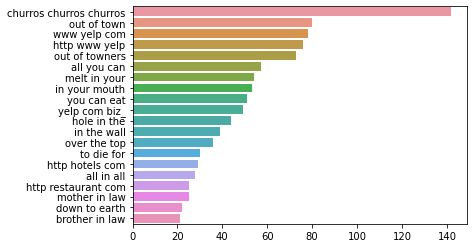

In [20]:

# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

nltk.download('stopwords')

def plot_top_ngrams_barchart(text, n=2):
    synthetic = {'gmail', 'they', 'http', 'www'}
    stop=set(stopwords.words('english')) | synthetic
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    

plot_top_ngrams_barchart(trueReviews['reviewContent'],3)

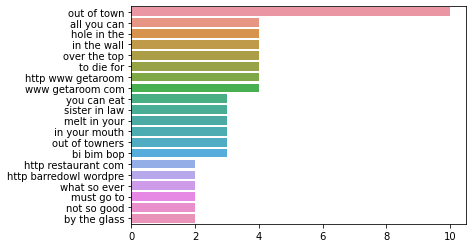

In [21]:
plot_top_ngrams_barchart(fakeReviews['reviewContent'],3)

# Baseline Model

Try a Plain LSTM model on the Hotel data set with fixed length learned embedding

# Hotels Dataset

In [22]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(hotel_X_train['reviewContent'])
sequences = tokenizer.texts_to_sequences(hotel_X_train['reviewContent'])
hotel_train_data = pad_sequences(sequences, maxlen=100)

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(hotel_X_dev['reviewContent'])
sequences = tokenizer.texts_to_sequences(hotel_X_dev['reviewContent'])
hotel_dev_data = pad_sequences(sequences, maxlen=100)


In [23]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=100))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [24]:
model.fit(hotel_train_data, hotel_y_train, epochs=2)

Epoch 1/2
107/107 [==============================] - 32s 276ms/step - loss: 0.4701 - accuracy: 0.8447
Epoch 2/2
107/107 [==============================] - 30s 279ms/step - loss: 0.3478 - accuracy: 0.8768


In [25]:
hotel_y_predicted = model.predict(hotel_dev_data)

In [26]:
print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))

              precision    recall  f1-score   support

       False       1.00      0.89      0.94      1133
        True       0.00      0.00      0.00         1

    accuracy                           0.89      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.89      0.94      1134



# Model 2 - Data Resampling + GloVe embedding

In [27]:
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')

Already downloaded the embedding


In [28]:
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [29]:
# Split the positive/negative samples for more balanced sampling
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

print(f'There are {len(hotel_X_train_positive)} positive examples')
print(f'There are {len(hotel_X_train_negative)} negative examples')

num_samples = 2000
positive_ratio = 0.3
hotel_positives = hotel_X_train_positive.sample(int(num_samples * positive_ratio), replace=True).reset_index(drop=True)
hotel_negatives = hotel_X_train_negative.sample(num_samples, replace=True).reset_index(drop=True)

hotel_X_train_balanced = pd.concat([hotel_positives, hotel_negatives], ignore_index=True).sample(frac=1)
hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'


There are 433 positive examples
There are 2969 negative examples


In [30]:
# First layer, vectorizing the word input
vocabulary_size = 30000
max_tokens = 200

vectorizer = TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_tokens)
vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print(f"Vocabulary size is {len(voc)}")


Vocabulary size is 13520


In [31]:
# Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
# Build + Lock in the Embedding layer from GloVe
embedding_dim = 100
hits = 0
misses = 0
num_words = len(voc) + 2

# Prepare embedding matrix
# TODO: more pre-processing to avoid ~3000 words that don't have embeddings
embedding_matrix = np.zeros((num_words, embedding_dim))
for i, word in enumerate(voc):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


embedding_layer = Embedding(
    num_words,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


Converted 10993 words (2527 misses)


In [32]:
# Vectorize the input
hotel_X_train_ready = vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
hotel_X_dev_ready = vectorizer(hotel_X_dev['reviewContent']).numpy()

hotel_X_train_ready.shape

(2600, 200)

In [33]:
# Build and train the model with 
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=8)

Epoch 1/8
82/82 [==============================] - 28s 307ms/step - loss: 0.6056 - accuracy: 0.7698
Epoch 2/8
82/82 [==============================] - 25s 301ms/step - loss: 0.5416 - accuracy: 0.7613
Epoch 3/8
82/82 [==============================] - 25s 301ms/step - loss: 0.5188 - accuracy: 0.7772
Epoch 4/8
82/82 [==============================] - 25s 304ms/step - loss: 0.5122 - accuracy: 0.7798
Epoch 5/8
82/82 [==============================] - 25s 301ms/step - loss: 0.5040 - accuracy: 0.7815
Epoch 6/8
82/82 [==============================] - 25s 303ms/step - loss: 0.5101 - accuracy: 0.7818
Epoch 7/8
82/82 [==============================] - 25s 304ms/step - loss: 0.5038 - accuracy: 0.7783
Epoch 8/8
82/82 [==============================] - 25s 303ms/step - loss: 0.4952 - accuracy: 0.7787


In [34]:
model.evaluate(hotel_X_dev_ready, hotel_y_dev)
hotel_y_predicted = model.predict(hotel_X_dev_ready)
print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev)

36/36 [==============================] - 3s 73ms/step - loss: 0.3955 - accuracy: 0.8686
              precision    recall  f1-score   support

       False       0.98      0.89      0.93      1109
        True       0.02      0.08      0.03        25

    accuracy                           0.87      1134
   macro avg       0.50      0.48      0.48      1134
weighted avg       0.96      0.87      0.91      1134



N    0.887125
Y    0.112875
Name: flagged, dtype: float64